In [69]:
!pip install folium pandas
!pip install shapely

In [70]:
import boto3
import pandas as pd
import io
from botocore.exceptions import ClientError
from shapely.geometry import Point, Polygon
import math
import folium
from folium import plugins
import numpy as np
import folium
import pandas as pd
from typing import Optional, Union, Tuple
import json
from ipywidgets import interact, FloatSlider, Layout
import ipywidgets as widgets
from shapely.vectorized import contains
import s3fs

In [71]:
# Initialize boto3 session and get credentials
session = boto3.Session()
credentials = session.get_credentials()

# Initialize S3 filesystem with boto3 credentials
s3 = s3fs.S3FileSystem(
    key=credentials.access_key,
    secret=credentials.secret_key,
    token=credentials.token,  # This will be included if using temporary credentials
    anon=False
)
# Read the parquet file
s3_path = 's3://birdsbucker/trainingdata/merged_data_8am_migration_weekend_weather_flag.parquet'
df_birds = pd.read_parquet(s3_path, filesystem=s3)

df_birds.head()

OBSERVATION COUNT STATE CODE LOCALITY TYPE   LATITUDE  LONGITUDE  \
0                 2      US-VA             H  38.146335 -77.443370   
1                 1      US-VA             P  38.183491 -77.424592   
2                 2      US-VA             H  38.146335 -77.443370   
3                 1      US-VA             P  38.183491 -77.424592   
4                 2      US-VA             H  38.148066 -77.440200   

  OBSERVATION DATE TIME OBSERVATIONS STARTED  i95_distance  \
0       2020-01-15                  08:50:00      0.875569   
1       2020-01-15                  08:27:00      0.386942   
2       2020-01-15                  08:50:00      0.875569   
3       2020-01-15                  08:27:00      0.386942   
4       2020-01-15                  08:36:00      0.732355   

                                   station_distances assigned_station  ...  \
0  {'000019': 1019.9471111116882, '000022': 958.2...           060164  ...   
1  {'000019': 1015.7567282177127, '000022': 954.0...           060164  ...   
2  {'000019': 1019.9471111116882, '000022': 958.2...           060164  ...   
3  {'000019': 1015.7567282177127, '000022': 954.0...           060164  ...   
4  {'000019': 1019.61976246388, '000022': 957.962...           060164  ...   

   restrictions  daily_avg_noise  peak_hour_noise  overnight_noise  \
0           0.0        91.648049        94.189788        88.499913   
1           0.0        91.648049        94.189788        88.499913   
2           0.0        91.648049        94.189788        88.499913   
3           0.0        91.648049        94.189788        88.499913   
4           0.0        91.648049        94.189788        88.499913   

   rush_hour_noise  total_daily_volume  noise_8am  is_weekend is_migration  \
0        93.493016             78503.0  93.963317         0.0            0   
1        93.493016             78503.0  93.963317         0.0            0   
2        93.493016             78503.0  93.963317         0.0            0   
3        93.493016             78503.0  93.963317         0.0            0   
4        93.493016             78503.0  93.963317         0.0            0   

  extreme_weather  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 56 columns]

## Initial Data Analysis

In [72]:
# Create a summary DataFrame with data types and null counts
summary = pd.DataFrame({
    'Data Type': df_birds.dtypes,
    'Null Count': df_birds.isnull().sum(),
    'Null Percentage': (df_birds.isnull().sum() / len(df_birds) * 100).round(2)
})

# Add total rows count for reference
print(f"Total rows in DataFrame: {len(df_birds)}\n")

# Display the summary
print(summary)

Total rows in DataFrame: 132076

                                Data Type  Null Count  Null Percentage
OBSERVATION COUNT                  object           0             0.00
STATE CODE                         object           0             0.00
LOCALITY TYPE                      object           0             0.00
LATITUDE                          float64           0             0.00
LONGITUDE                         float64           0             0.00
OBSERVATION DATE           datetime64[ns]           0             0.00
TIME OBSERVATIONS STARTED          object           0             0.00
i95_distance                      float64           0             0.00
station_distances                  object           0             0.00
assigned_station                   object           0             0.00
year_record                         int32           0             0.00
month_record                         int8           0             0.00
day_record                           int8   

In [73]:
# Check number of rows before dropping
print("Number of rows before:", len(df_birds))

# Drop rows where OBSERVATION COUNT is 'X'
df_birds = df_birds[df_birds['OBSERVATION COUNT'] != 'X']

# Check number of rows after dropping
print("Number of rows after:", len(df_birds))

# Convert column to numeric if not already
df_birds['OBSERVATION COUNT'] = pd.to_numeric(df_birds['OBSERVATION COUNT'])

# Verify the changes
print("\nData type:", df_birds['OBSERVATION COUNT'].dtype)
print("\nUnique values:", sorted(df_birds['OBSERVATION COUNT'].unique()))
print("\nNumber of null values:", df_birds['OBSERVATION COUNT'].isnull().sum())

Number of rows before: 132076
Number of rows after: 129288

Data type: int64

Unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 128, 129, 130, 132, 133, 134, 135, 137, 139, 140, 143, 144, 145, 146, 147, 148, 150, 152, 153, 154, 155, 157, 158, 160, 162, 163, 164, 165, 166, 168, 170, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 185, 186, 187, 188, 190, 192, 193, 195, 196, 199, 200, 205, 206, 210, 211, 212, 213, 214, 215, 220, 224, 225, 226, 227, 230, 231, 235, 240, 243, 244, 245, 250, 255, 257, 260, 265, 270, 275, 277, 280, 285

In [74]:
# Group by OBSERVATION COUNT and count occurrences
count_summary = df_birds.groupby('OBSERVATION COUNT').size().reset_index(name='frequency')

# Sort by OBSERVATION COUNT for better readability
count_summary = count_summary.sort_values('OBSERVATION COUNT')

# Add percentage column
count_summary['percentage'] = (count_summary['frequency'] / count_summary['frequency'].sum() * 100).round(2)

# Display the results with all columns
print("Summary of OBSERVATION COUNT frequencies:")
print(count_summary.to_string())

# Display summary statistics
print("\nSummary Statistics:")
print(f"Total observations: {count_summary['frequency'].sum():,}")
print(f"Most common count: {count_summary.iloc[count_summary['frequency'].idxmax()]['OBSERVATION COUNT']}")
print(f"Number of different count values: {len(count_summary)}")

Summary of OBSERVATION COUNT frequencies:
     OBSERVATION COUNT  frequency  percentage
0                    1      53889       41.68
1                    2      28565       22.09
2                    3      12785        9.89
3                    4       8496        6.57
4                    5       5102        3.95
5                    6       4176        3.23
6                    7       2039        1.58
7                    8       2202        1.70
8                    9        968        0.75
9                   10       1517        1.17
10                  11        676        0.52
11                  12       1044        0.81
12                  13        348        0.27
13                  14        497        0.38
14                  15        832        0.64
15                  16        377        0.29
16                  17        281        0.22
17                  18        313        0.24
18                  19        162        0.13
19                  20        621     

In [75]:
# First, let's see what columns we actually have
print("Available columns:", df_birds.columns.tolist())

# More robust approach handling potential format variations
def convert_to_time(time_str):
    try:
        return pd.to_datetime(time_str).time()
    except:
        return pd.NaT

# Now let's try to find the correct column name for time
time_columns = [col for col in df_birds.columns if 'TIME' in col.upper()]
print("\nColumns containing 'TIME':", time_columns)

# If we find the correct column, let's use it
if time_columns:
    correct_column = time_columns[0]  # Use the first matching column
    df_birds[correct_column] = df_birds[correct_column].apply(convert_to_time)
    
    # Verify the conversion
    print(f"\nData type: {df_birds[correct_column].dtype}")
    print("\nFirst few values:")
    print(df_birds[correct_column].head())
    print(f"\nNumber of null values: {df_birds[correct_column].isnull().sum()}")
else:
    print("\nNo time-related columns found. Please check the column names.")

Available columns: ['OBSERVATION COUNT', 'STATE CODE', 'LOCALITY TYPE', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'TIME OBSERVATIONS STARTED', 'i95_distance', 'station_distances', 'assigned_station', 'year_record', 'month_record', 'day_record', 'hour_started', 'state_code', 'day_of_week', 'latitude', 'longitude', 'station_location', 'state', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'record_type', 'f_system', 'restrictions', 'daily_avg_noise', 'peak_hour_noise', 'overnight_noise', 'rush_hour_noise', 'total_daily_volume', 'noise_8am', 'is_weekend', 'is_migration', 'extreme_weather']

Columns containing 'TIME': ['TIME OBSERVATIONS STARTED']

Data type: object

First few values:
0    08:50:00
1    08:27:00
2    08:50:00
3    08:27:00
4    08:36:00
Name: TIME OBSERVATI

In [76]:
df_birds= df_birds[['OBSERVATION COUNT', 'STATE CODE', 'LOCALITY TYPE', 'LATITUDE',
       'LONGITUDE', 'OBSERVATION DATE', 'TIME OBSERVATIONS STARTED',
       'i95_distance', 'assigned_station', 'year_record',
       'month_record', 'day_record', 'hour_started', 'state_code',
       'day_of_week', 'latitude', 'longitude',  'state', 'noise_8am','is_migration', 'is_weekend',
       'extreme_weather']]

df_birds.head()

OBSERVATION COUNT STATE CODE LOCALITY TYPE   LATITUDE  LONGITUDE  \
0                  2      US-VA             H  38.146335 -77.443370   
1                  1      US-VA             P  38.183491 -77.424592   
2                  2      US-VA             H  38.146335 -77.443370   
3                  1      US-VA             P  38.183491 -77.424592   
4                  2      US-VA             H  38.148066 -77.440200   

  OBSERVATION DATE TIME OBSERVATIONS STARTED  i95_distance assigned_station  \
0       2020-01-15                  08:50:00      0.875569           060164   
1       2020-01-15                  08:27:00      0.386942           060164   
2       2020-01-15                  08:50:00      0.875569           060164   
3       2020-01-15                  08:27:00      0.386942           060164   
4       2020-01-15                  08:36:00      0.732355           060164   

   year_record  ...  hour_started  state_code  day_of_week  latitude  \
0         2020  ...             8        51.0          4.0  38.14136   
1         2020  ...             8        51.0          4.0  38.14136   
2         2020  ...             8        51.0          4.0  38.14136   
3         2020  ...             8        51.0          4.0  38.14136   
4         2020  ...             8        51.0          4.0  38.14136   

   longitude  state  noise_8am is_migration  is_weekend  extreme_weather  
0  -77.50652     VA  93.963317            0         0.0                0  
1  -77.50652     VA  93.963317            0         0.0                0  
2  -77.50652     VA  93.963317            0         0.0                0  
3  -77.50652     VA  93.963317            0         0.0                0  
4  -77.50652     VA  93.963317            0         0.0                0  

[5 rows x 22 columns]

### Dropping where noise is null

In [77]:
# Check number of rows before dropping
print("Number of rows before:", len(df_birds))

# Drop rows where noise_8am is null
df_birds = df_birds.dropna(subset=['noise_8am'])

# Check number of rows after dropping
print("Number of rows after:", len(df_birds))

# Show info about remaining null values in the dataset
print("\nRemaining null values in the dataset:")
print(df_birds.isnull().sum())

# Optional: Display first few rows to verify
print("\nFirst few rows after dropping:")
print(df_birds[['noise_8am']].head())

Number of rows before: 129288
Number of rows after: 98501

Remaining null values in the dataset:
OBSERVATION COUNT            0
STATE CODE                   0
LOCALITY TYPE                0
LATITUDE                     0
LONGITUDE                    0
OBSERVATION DATE             0
TIME OBSERVATIONS STARTED    0
i95_distance                 0
assigned_station             0
year_record                  0
month_record                 0
day_record                   0
hour_started                 0
state_code                   0
day_of_week                  0
latitude                     0
longitude                    0
state                        0
noise_8am                    0
is_migration                 0
is_weekend                   0
extreme_weather              0
dtype: int64

First few rows after dropping:
   noise_8am
0  93.963317
1  93.963317
2  93.963317
3  93.963317
4  93.963317


### Filtering by weekend

In [78]:
df_birds = df_birds[df_birds['is_weekend'] == 1]
len(df_birds)

37273

In [79]:
# Create a summary DataFrame with data types and null counts
summary = pd.DataFrame({
    'Data Type': df_birds.dtypes,
    'Null Count': df_birds.isnull().sum(),
    'Null Percentage': (df_birds.isnull().sum() / len(df_birds) * 100).round(2)
})

# Add total rows count for reference
print(f"Total rows in DataFrame: {len(df_birds)}\n")

# Display the summary
print(summary)

Total rows in DataFrame: 37273

                                Data Type  Null Count  Null Percentage
OBSERVATION COUNT                   int64           0              0.0
STATE CODE                         object           0              0.0
LOCALITY TYPE                      object           0              0.0
LATITUDE                          float64           0              0.0
LONGITUDE                         float64           0              0.0
OBSERVATION DATE           datetime64[ns]           0              0.0
TIME OBSERVATIONS STARTED          object           0              0.0
i95_distance                      float64           0              0.0
assigned_station                   object           0              0.0
year_record                         int32           0              0.0
month_record                         int8           0              0.0
day_record                           int8           0              0.0
hour_started                        int32    

<Figure size 1200x800 with 0 Axes>

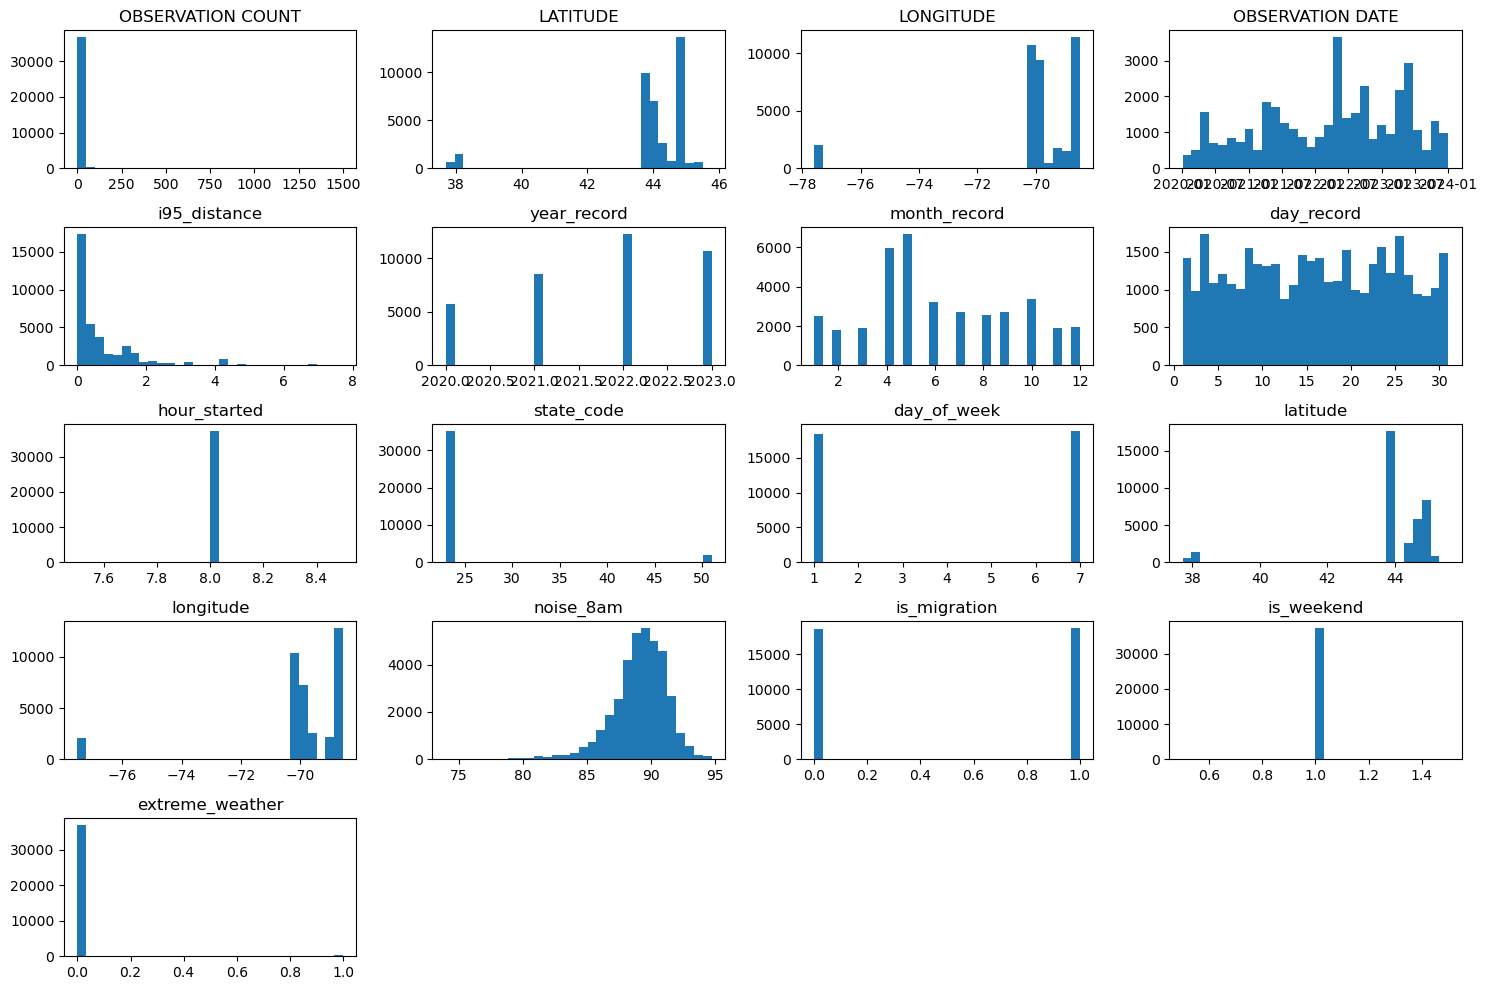

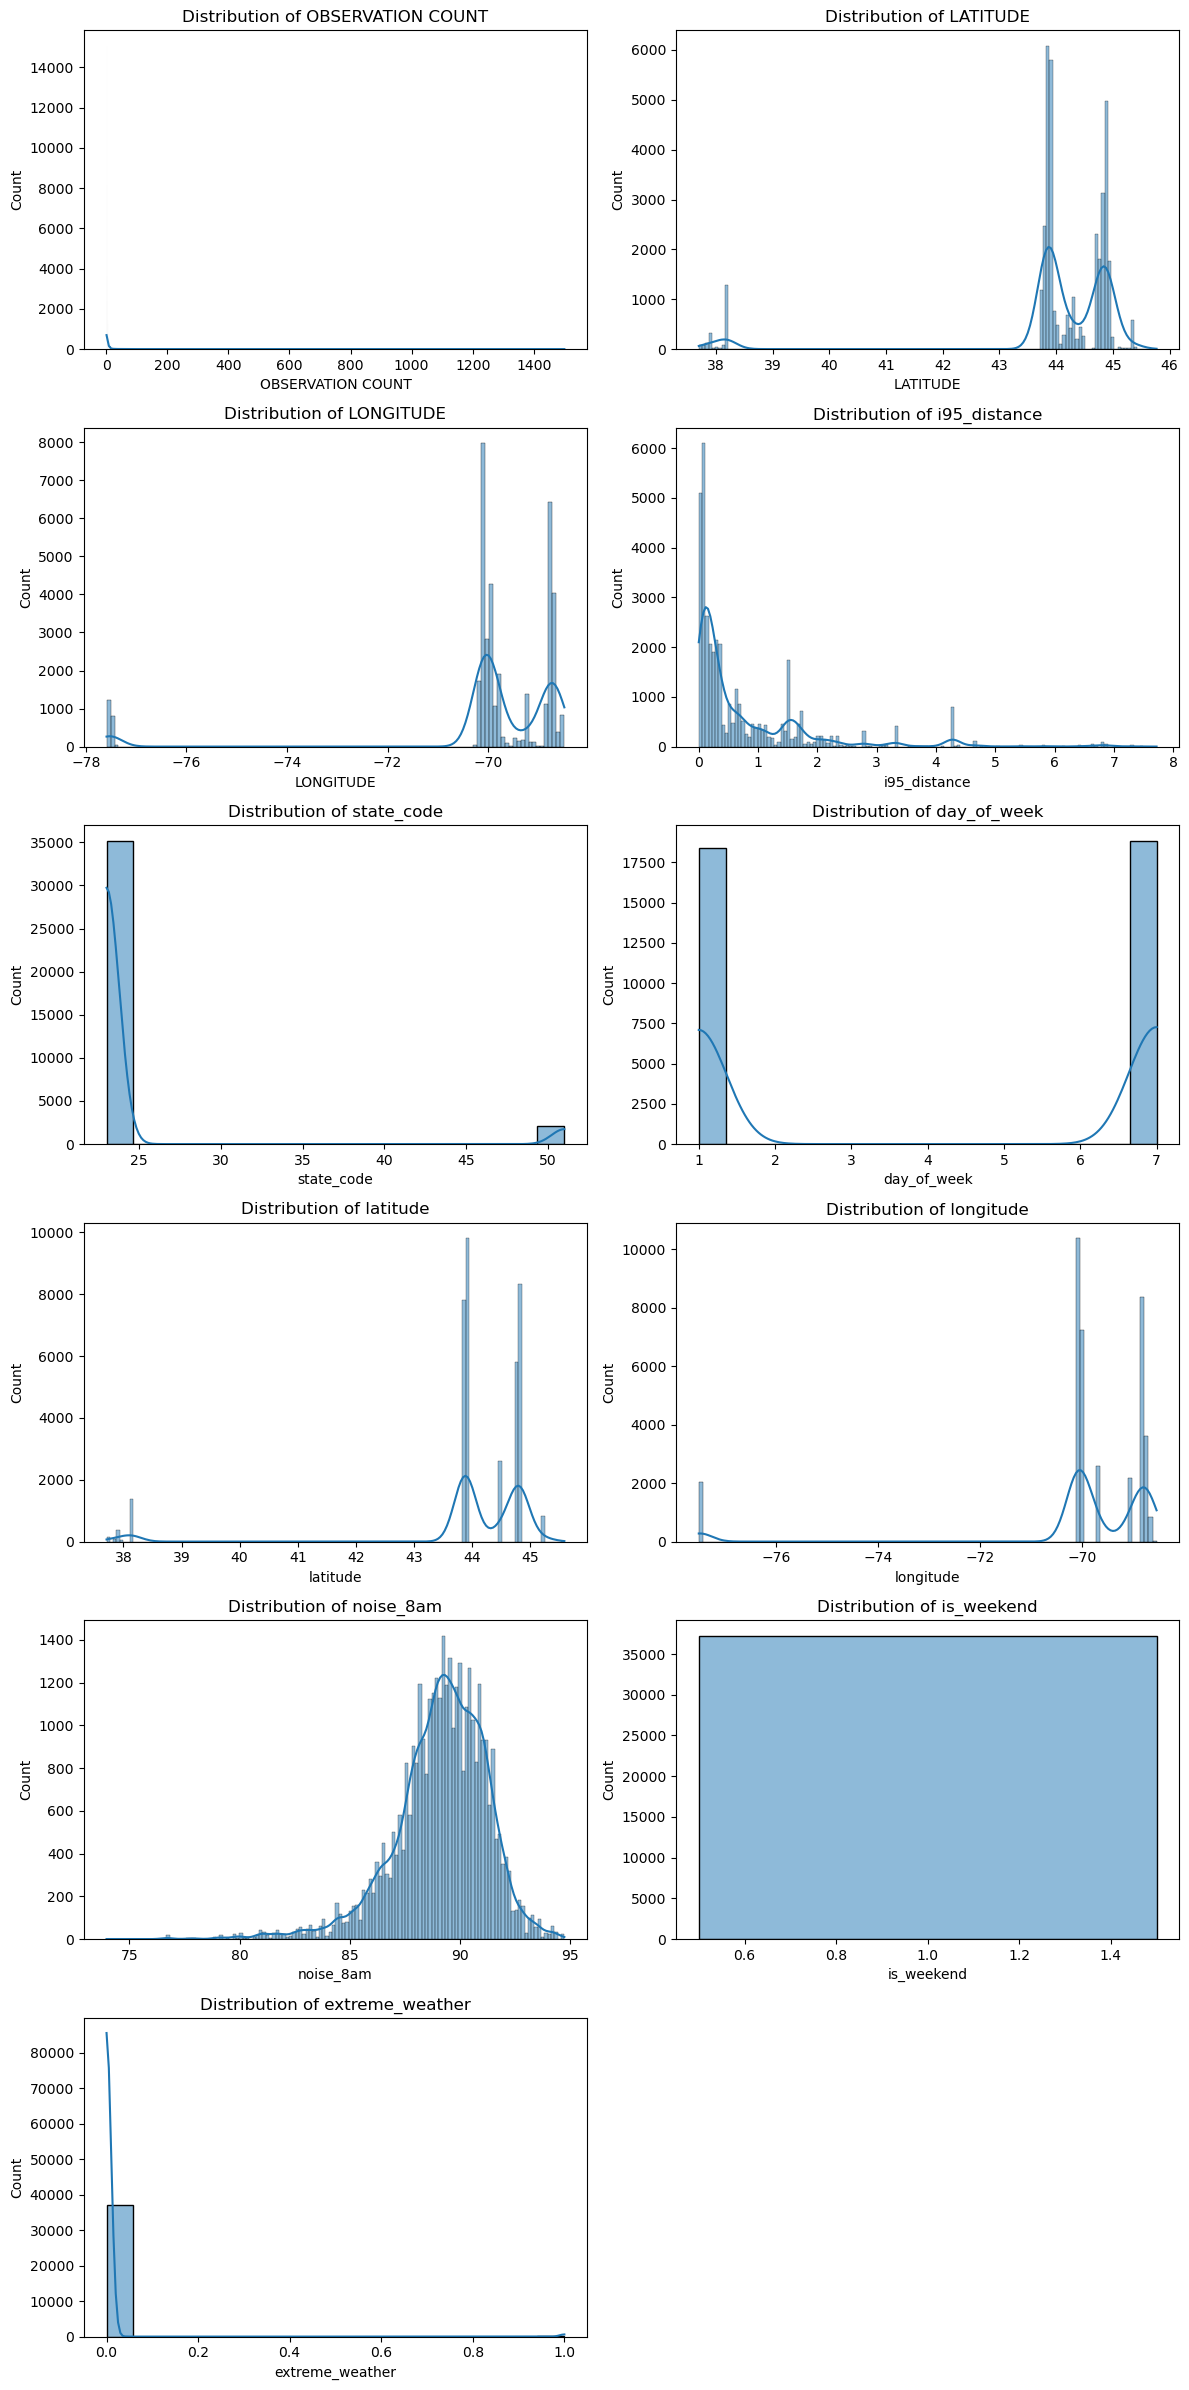

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Create a figure with larger size for better visibility
plt.figure(figsize=(12, 8))

# Create histograms for all applicable columns
df_birds.hist(bins=30, figsize=(15, 10), grid=False)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# For a more detailed analysis with individual control, you can use:
def plot_distributions(df, columns=None):
    if columns is None:
        # Select only numeric columns
        columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Calculate number of rows and columns for subplot grid
    n_cols = 2
    n_rows = (len(columns) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
    axes = axes.ravel() # Flatten axes array
    
    for idx, col in enumerate(columns):
        # Create histogram with KDE
        sns.histplot(data=df, x=col, kde=True, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
    
    # Remove empty subplots if any
    for idx in range(len(columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Use the function
plot_distributions(df_birds)

In [81]:
df_birds.columns

Index(['OBSERVATION COUNT', 'STATE CODE', 'LOCALITY TYPE', 'LATITUDE',
       'LONGITUDE', 'OBSERVATION DATE', 'TIME OBSERVATIONS STARTED',
       'i95_distance', 'assigned_station', 'year_record', 'month_record',
       'day_record', 'hour_started', 'state_code', 'day_of_week', 'latitude',
       'longitude', 'state', 'noise_8am', 'is_migration', 'is_weekend',
       'extreme_weather'],
      dtype='object')

### Grouping counts per station and date

In [91]:
# Group by the specified columns and aggregate with both sum and mean
grouped_df = df_birds.groupby(['assigned_station', 
                             'OBSERVATION DATE']).agg({
    'OBSERVATION COUNT': 'sum',
    'noise_8am': 'mean'
}).reset_index()


# Round noise_8am mean to 2 decimal places for cleaner display
grouped_df['noise_8am'] = grouped_df['noise_8am'].round(2)

# Display the first few rows
print("First few rows of the grouped data:")
print(grouped_df.head())

# Display summary statistics
print("\nSummary Statistics:")
print(f"Number of unique stations: {grouped_df['assigned_station'].nunique()}")
print(f"Date range: {grouped_df['OBSERVATION DATE'].min()} to {grouped_df['OBSERVATION DATE'].max()}")
print(f"Total sum of observations: {grouped_df['OBSERVATION COUNT'].sum():,}")
print(f"Average noise level: {grouped_df['noise_8am'].mean():.2f}")

First few rows of the grouped data:
  assigned_station OBSERVATION DATE  OBSERVATION COUNT  noise_8am
0           030209       2020-01-05                 15      87.27
1           030209       2020-01-18                 41      89.40
2           030209       2020-01-25                112      89.92
3           030209       2020-02-01                  9      89.62
4           030209       2020-02-02                 16      87.99

Summary Statistics:
Number of unique stations: 32
Date range: 2020-01-04 00:00:00 to 2023-12-31 00:00:00
Total sum of observations: 212,739
Average noise level: 88.74


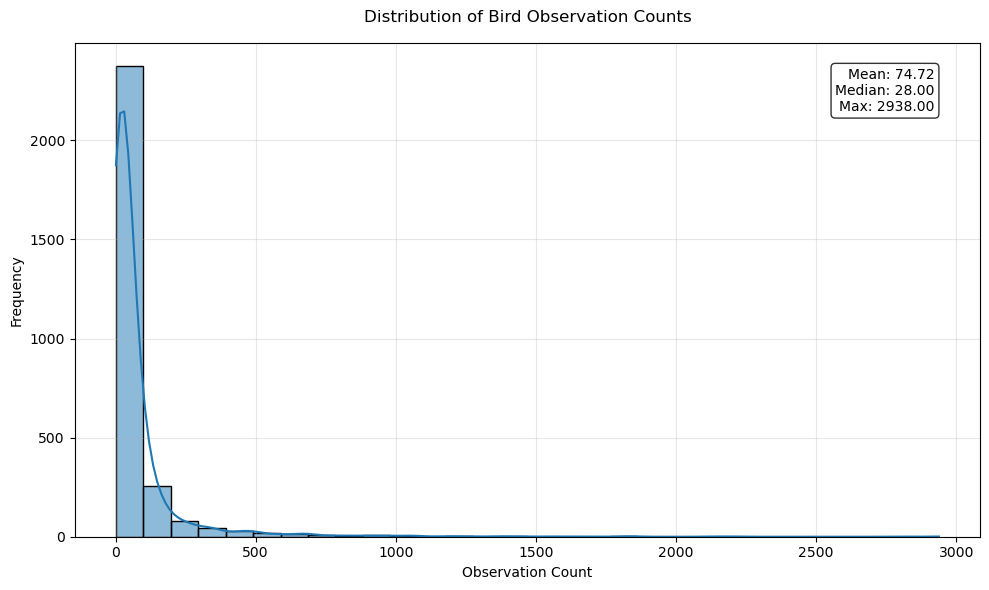


Numerical Summary of Observation Counts:
count    2847.000000
mean       74.723920
std       173.651693
min         1.000000
25%        10.000000
50%        28.000000
75%        67.000000
max      2938.000000
Name: OBSERVATION COUNT, dtype: float64


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Create histogram
sns.histplot(data=grouped_df, x='OBSERVATION COUNT', bins=30, kde=True)

# Customize the plot
plt.title('Distribution of Bird Observation Counts', fontsize=12, pad=15)
plt.xlabel('Observation Count', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add summary statistics as text
stats_text = f'Mean: {grouped_df["OBSERVATION COUNT"].mean():.2f}\n'
stats_text += f'Median: {grouped_df["OBSERVATION COUNT"].median():.2f}\n'
stats_text += f'Max: {grouped_df["OBSERVATION COUNT"].max():.2f}'
plt.text(0.95, 0.95, stats_text,
         transform=ax.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print numerical summary
print("\nNumerical Summary of Observation Counts:")
print(grouped_df['OBSERVATION COUNT'].describe())

/opt/conda/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


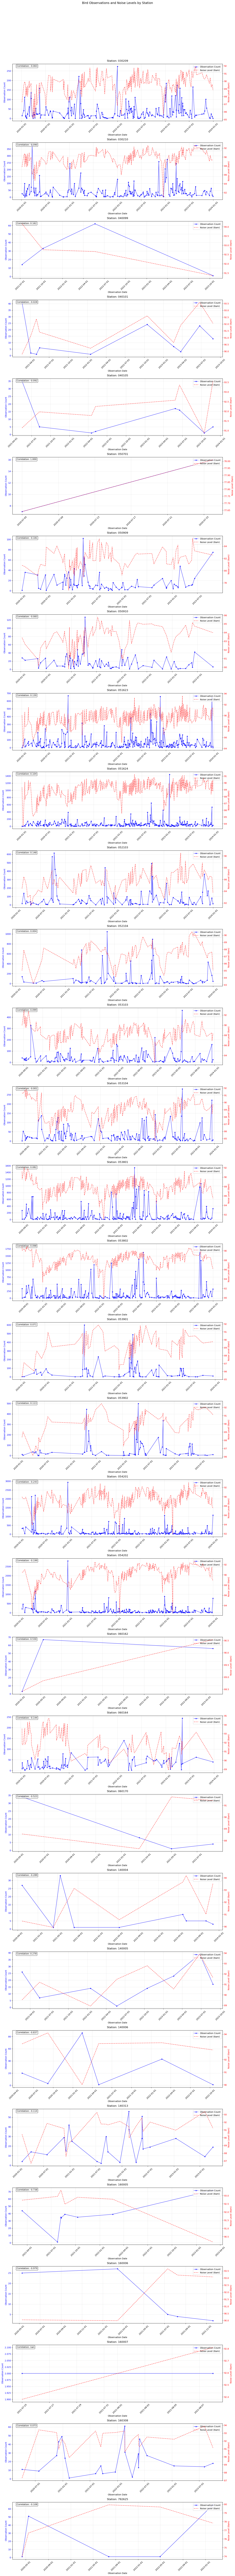


Summary Statistics for 030209:

Observation Count Statistics:
count    192.00
mean      36.32
std       43.32
min        1.00
25%        8.00
50%       23.00
75%       46.00
max      273.00
Name: OBSERVATION COUNT, dtype: float64

Noise Level Statistics:
count    192.00
mean      89.48
std        1.36
min       85.16
25%       88.74
50%       89.61
75%       90.39
max       91.92
Name: noise_8am, dtype: float64

Summary Statistics for 030210:

Observation Count Statistics:
count    182.00
mean      42.38
std       53.60
min        1.00
25%       11.25
50%       25.00
75%       51.75
max      378.00
Name: OBSERVATION COUNT, dtype: float64

Noise Level Statistics:
count    182.00
mean      89.74
std        1.67
min       81.02
25%       88.76
50%       90.00
75%       90.84
max       92.67
Name: noise_8am, dtype: float64

Summary Statistics for 040099:

Observation Count Statistics:
count     4.00
mean     27.50
std      26.49
min       1.00
25%      10.75
50%      23.50
75%      40.25


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

# Get unique stations
stations = grouped_df['assigned_station'].unique()
n_stations = len(stations)

# Create subplots, one for each station
fig, axes = plt.subplots(n_stations, 1, figsize=(15, 5*n_stations))
fig.suptitle('Bird Observations and Noise Levels by Station', fontsize=14, y=1.02)

# Plot for each station
for idx, station in enumerate(stations):
    # Get data for this station
    station_data = grouped_df[grouped_df['assigned_station'] == station]
    
    # Create twin axes for dual y-axis plot
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    # Plot observation counts
    line1 = ax1.plot(station_data['OBSERVATION DATE'], 
                     station_data['OBSERVATION COUNT'],
                     color='blue',
                     marker='o',
                     markersize=4,
                     label='Observation Count',
                     alpha=0.7)
    
    # Plot noise levels
    line2 = ax2.plot(station_data['OBSERVATION DATE'],
                     station_data['noise_8am'],
                     color='red',
                     linestyle='--',
                     label='Noise Level (8am)',
                     alpha=0.7)
    
    # Customize axes
    ax1.set_xlabel('Observation Date')
    ax1.set_ylabel('Observation Count', color='blue')
    ax2.set_ylabel('Noise Level (8am)', color='red')
    
    # Set tick colors
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Rotate x-axis labels
    ax1.tick_params(axis='x', rotation=45)
    
    # Format date on x-axis
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    
    # Add station name as subtitle
    ax1.set_title(f'Station: {station}', pad=10)
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    # Calculate correlation for this station
    correlation = station_data['OBSERVATION COUNT'].corr(station_data['noise_8am'])
    
    # Add correlation text
    ax1.text(0.02, 0.98, f'Correlation: {correlation:.3f}',
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics for each station
for station in stations:
    station_data = grouped_df[grouped_df['assigned_station'] == station]
    print(f"\nSummary Statistics for {station}:")
    print("\nObservation Count Statistics:")
    print(station_data['OBSERVATION COUNT'].describe().round(2))
    print("\nNoise Level Statistics:")
    print(station_data['noise_8am'].describe().round(2))

In [ ]:
len(grouped_df)

<Figure size 1200x800 with 0 Axes>

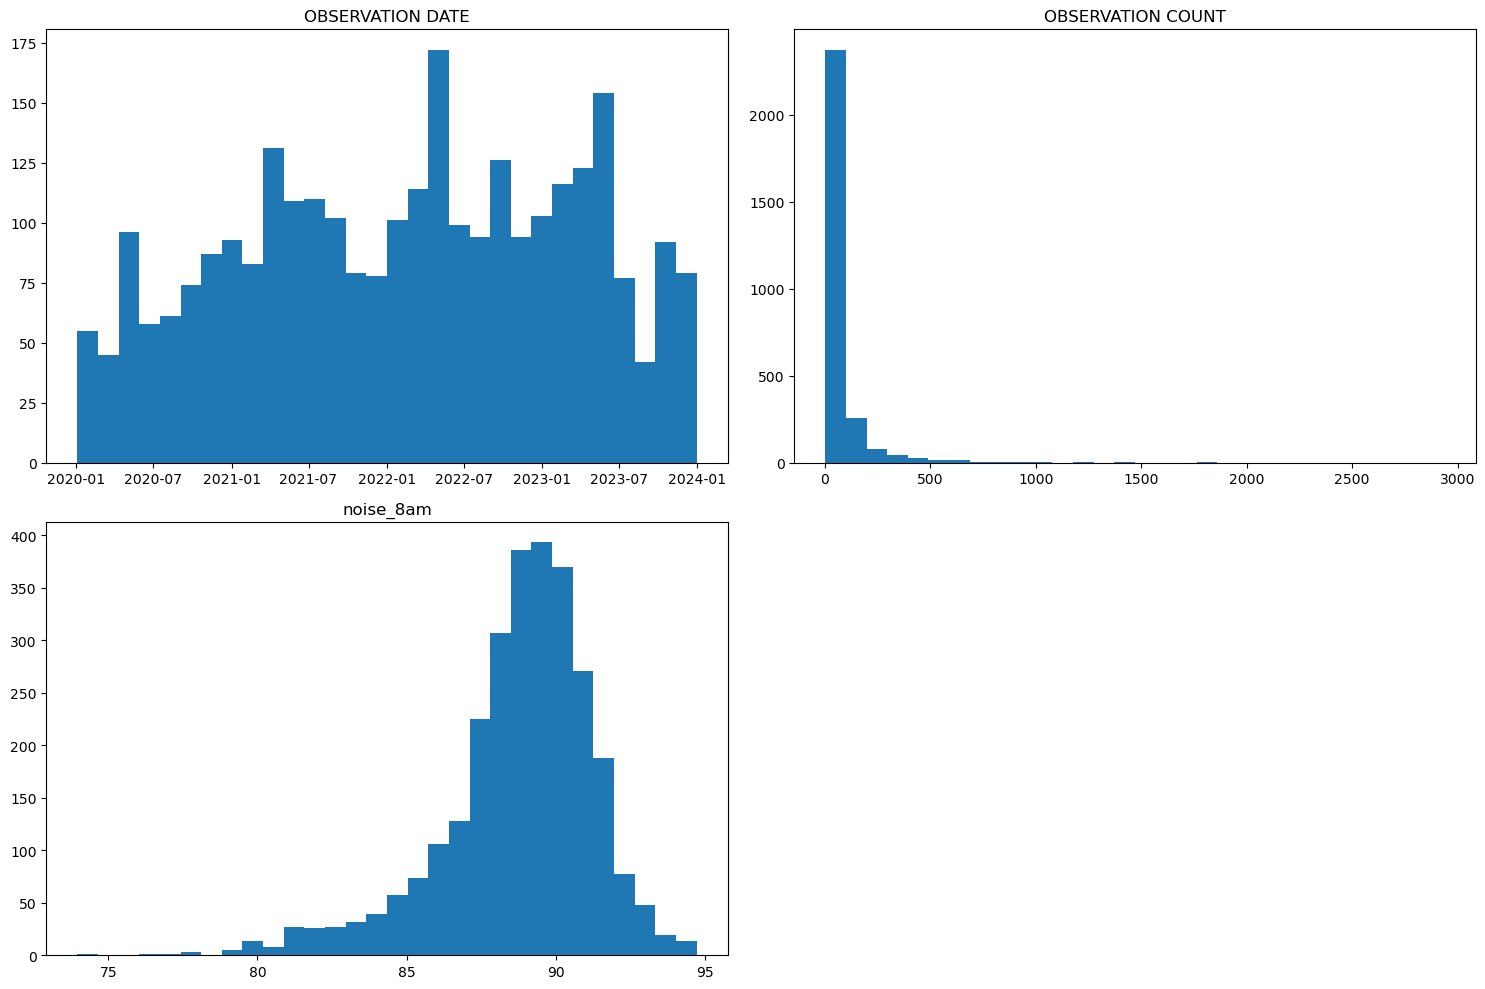

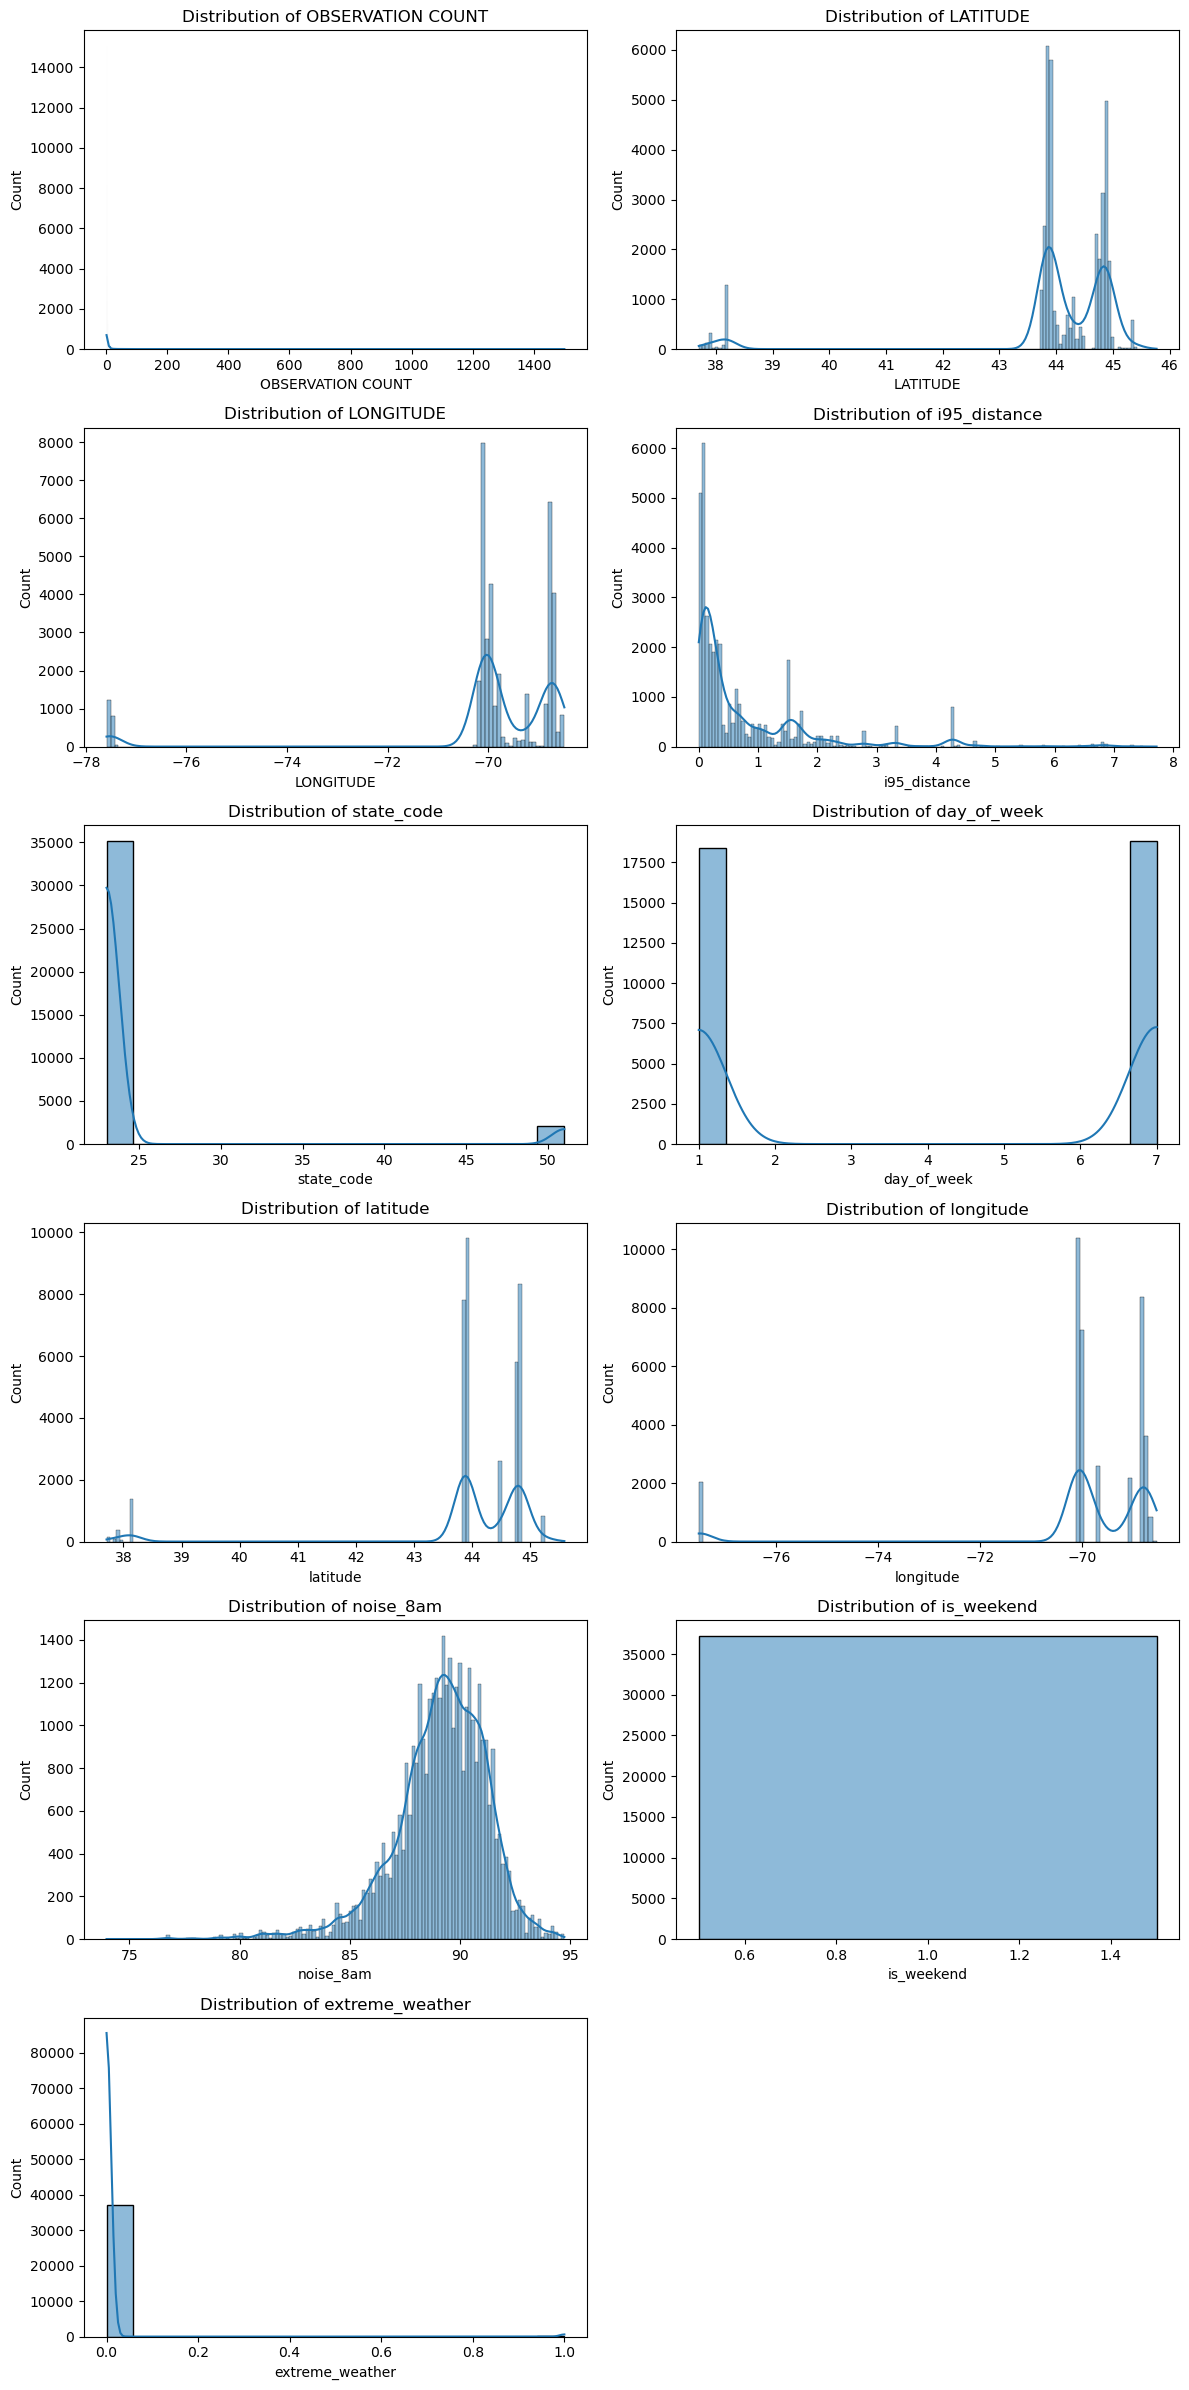

In [100]:
# Create a figure with larger size for better visibility
plt.figure(figsize=(12, 8))

# Create histograms for all applicable columns
grouped_df.hist(bins=30, figsize=(15, 10), grid=False)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
plot_distributions(df_birds)

In [101]:
grouped_df.columns

Index(['assigned_station', 'OBSERVATION DATE', 'OBSERVATION COUNT',
       'noise_8am'],
      dtype='object')

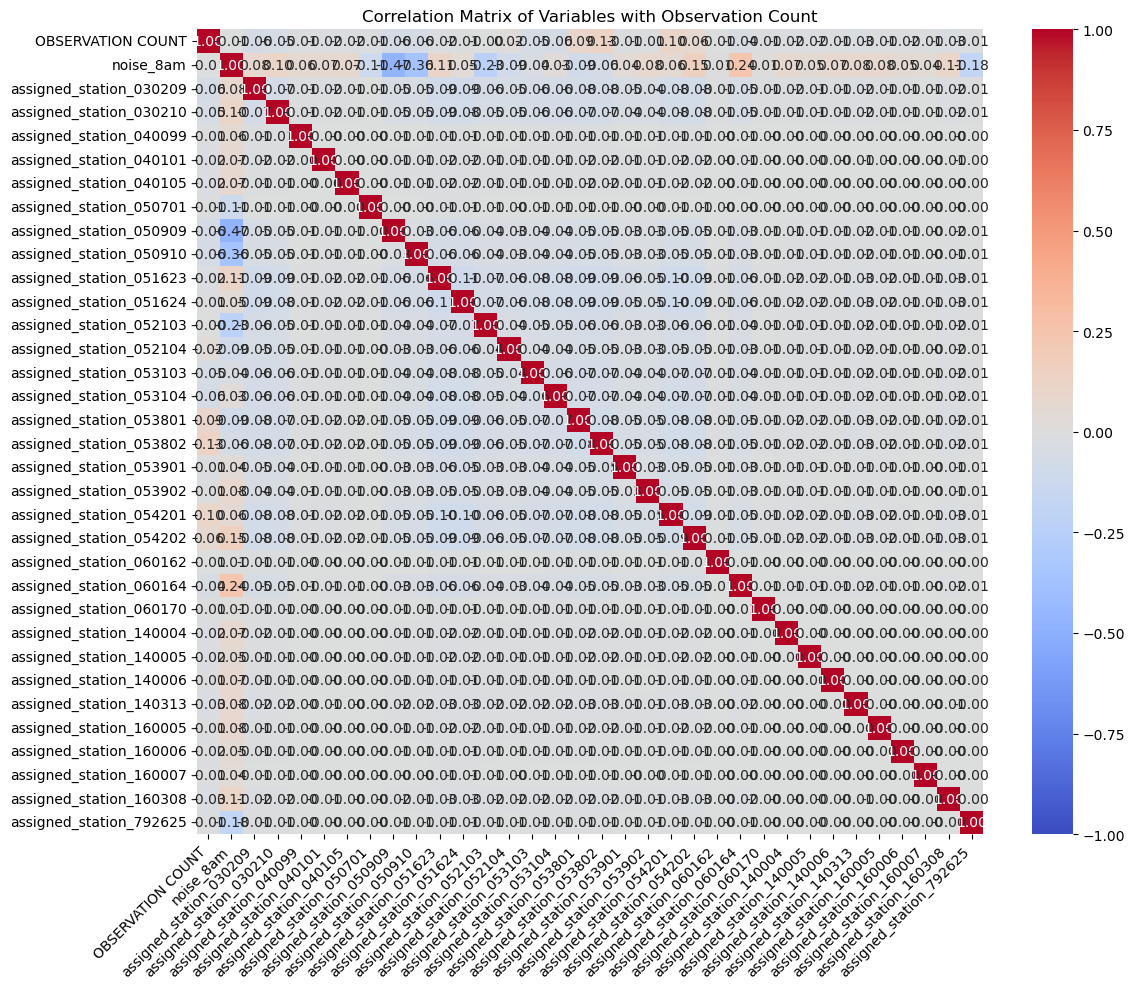


Correlations with OBSERVATION COUNT:
OBSERVATION COUNT          1.000000
assigned_station_053802    0.128622
assigned_station_054201    0.101684
assigned_station_053801    0.092683
assigned_station_054202    0.064577
assigned_station_052104    0.021353
assigned_station_052103   -0.001115
assigned_station_060162   -0.006122
noise_8am                 -0.006538
assigned_station_050701   -0.009655
assigned_station_040099   -0.010202
assigned_station_160007   -0.011106
assigned_station_160005   -0.011419
assigned_station_053902   -0.011748
assigned_station_053901   -0.011937
assigned_station_792625   -0.012302
assigned_station_140006   -0.012985
assigned_station_060170   -0.013605
assigned_station_051624   -0.014941
assigned_station_160006   -0.015008
assigned_station_140005   -0.017458
assigned_station_040105   -0.019713
assigned_station_140004   -0.021173
assigned_station_051623   -0.021187
assigned_station_040101   -0.021414
assigned_station_160308   -0.026343
assigned_station_140313   

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

# First, let's create dummy variables for categorical columns
categorical_cols = ['assigned_station']
numerical_cols = ['OBSERVATION COUNT', 'noise_8am']

# Create dummy variables for categorical columns
dummy_df = pd.get_dummies(grouped_df[categorical_cols])

# Combine with numerical columns
analysis_df = pd.concat([grouped_df[numerical_cols], dummy_df], axis=1)

# Calculate correlation matrix
correlation_matrix = analysis_df.corr()

# Create a figure with appropriate size
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            fmt='.2f')

plt.title('Correlation Matrix of Variables with Observation Count')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print correlations specifically with OBSERVATION COUNT
print("\nCorrelations with OBSERVATION COUNT:")
obs_count_corr = correlation_matrix['OBSERVATION COUNT'].sort_values(ascending=False)
print(obs_count_corr)

# Additional analysis for categorical variables
def cramers_v(var1, var2):
    """Calculate Cramer's V statistic for categorical variables"""
    confusion_matrix = pd.crosstab(var1, var2)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Calculate association between categorical variables and OBSERVATION COUNT
print("\nCramer's V Association with OBSERVATION COUNT:")
for cat_col in categorical_cols:
    cramer_v = cramers_v(grouped_df[cat_col], 
                        pd.qcut(grouped_df['OBSERVATION COUNT'], q=5))
    print(f"{cat_col}: {cramer_v:.3f}")






Numerical Variables Summary:
       OBSERVATION COUNT    noise_8am
count        2847.000000  2847.000000
mean           74.723920    88.735307
std           173.651693     2.558954
min             1.000000    73.960000
25%            10.000000    87.640000
50%            28.000000    89.130000
75%            67.000000    90.405000
max          2938.000000    94.730000


/tmp/ipykernel_295/298310660.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


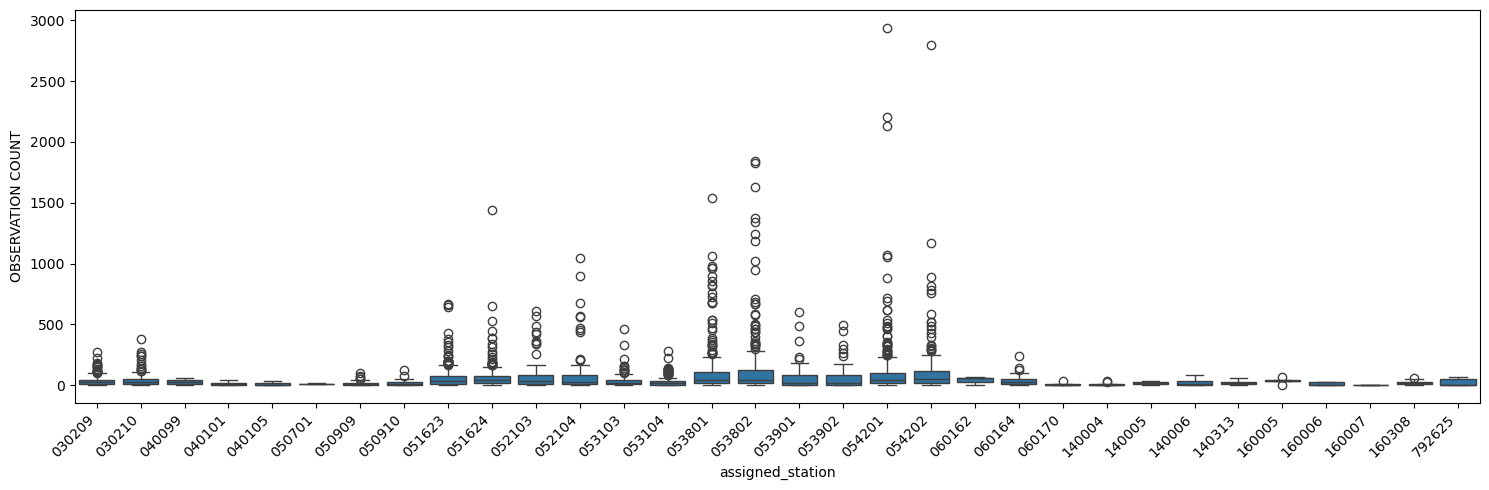

In [108]:
# Basic statistics for numerical variables
print("\nNumerical Variables Summary:")
print(grouped_df[numerical_cols].describe())

# Box plots for categorical variables
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(15, 5))
# Make axes an array even if there's only one subplot
axes = np.array([axes]) if len(categorical_cols) == 1 else axes

for i, col in enumerate(categorical_cols):
    sns.boxplot(data=grouped_df, x=col, y='OBSERVATION COUNT', ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

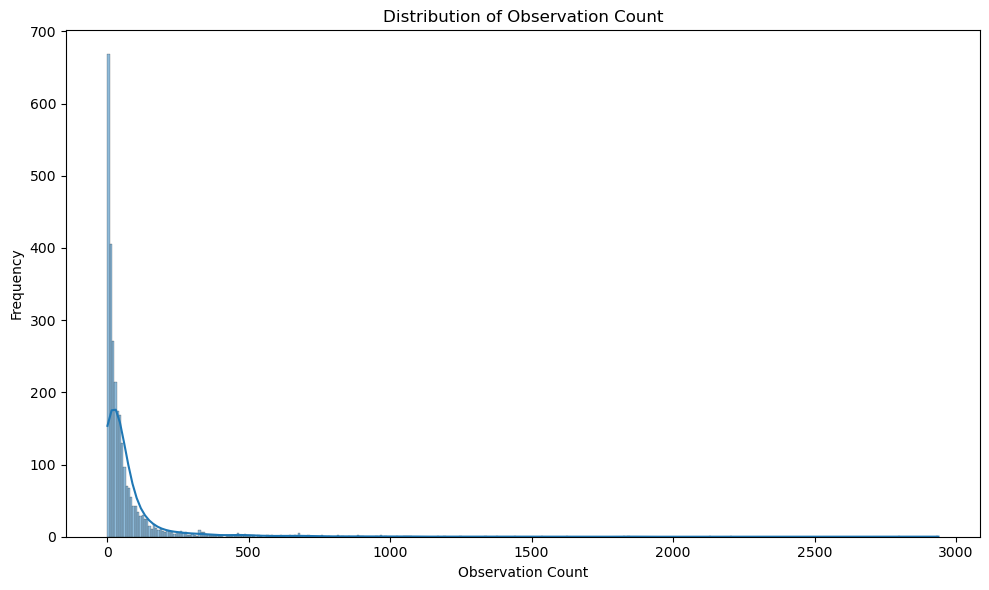

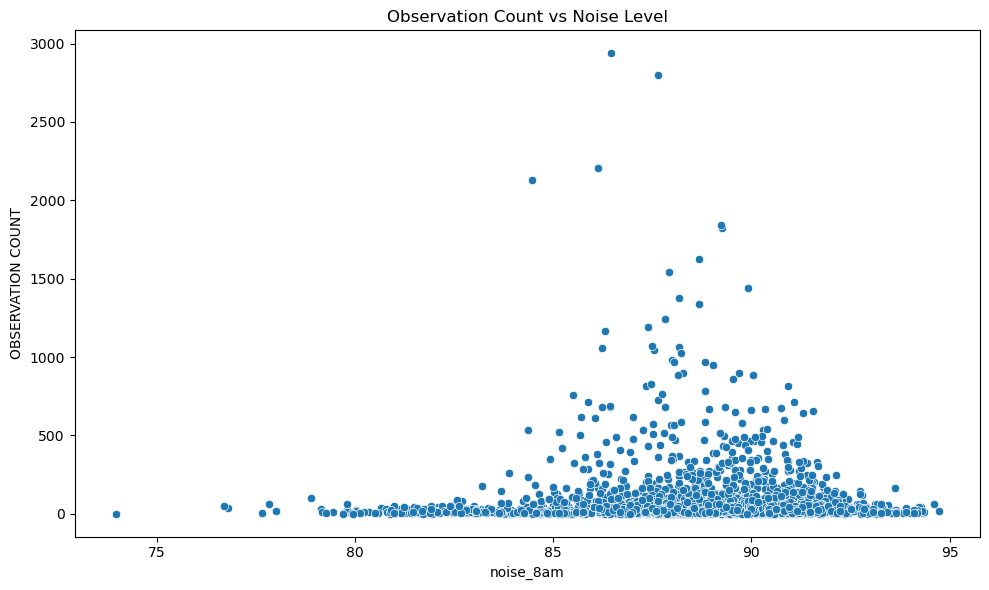

In [105]:
# Distribution of OBSERVATION COUNT
plt.figure(figsize=(10, 6))
sns.histplot(data=grouped_df, x='OBSERVATION COUNT', kde=True)
plt.title('Distribution of Observation Count')
plt.xlabel('Observation Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Scatter plot for numerical variables
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_df, x='noise_8am', y='OBSERVATION COUNT')
plt.title('Observation Count vs Noise Level')
plt.tight_layout()
plt.show()

Correlation between OBSERVATION COUNT and noise_8am: -0.007


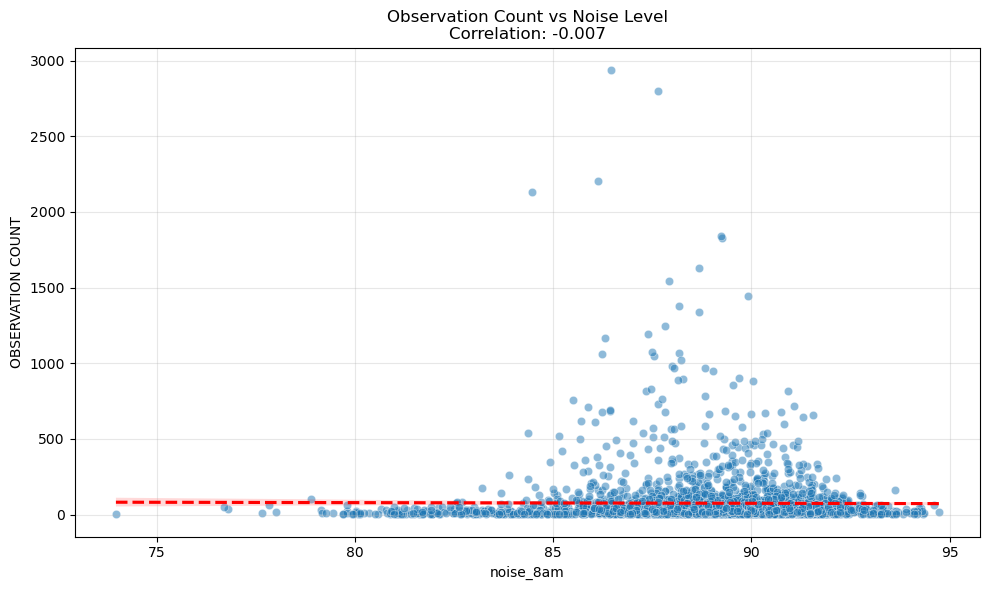


Detailed Statistics:

OBSERVATION COUNT:
count    2847.000000
mean       74.723920
std       173.651693
min         1.000000
25%        10.000000
50%        28.000000
75%        67.000000
max      2938.000000
Name: OBSERVATION COUNT, dtype: float64

noise_8am:
count    2847.000000
mean       88.735307
std         2.558954
min        73.960000
25%        87.640000
50%        89.130000
75%        90.405000
max        94.730000
Name: noise_8am, dtype: float64


In [109]:
# Calculate Pearson correlation
correlation = grouped_df['OBSERVATION COUNT'].corr(grouped_df['noise_8am'])

print(f"Correlation between OBSERVATION COUNT and noise_8am: {correlation:.3f}")

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_df, x='noise_8am', y='OBSERVATION COUNT', alpha=0.5)
plt.title(f'Observation Count vs Noise Level\nCorrelation: {correlation:.3f}')
plt.xlabel('Noise Level (8am)')
plt.ylabel('Observation Count')

# Add regression line
sns.regplot(data=grouped_df, x='noise_8am', y='OBSERVATION COUNT', 
            scatter=False, color='red', line_kws={'linestyle': '--'})

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Additional statistical details
print("\nDetailed Statistics:")
print("\nOBSERVATION COUNT:")
print(grouped_df['OBSERVATION COUNT'].describe())
print("\nnoise_8am:")
print(grouped_df['noise_8am'].describe())